# Step 5: Fusion Model Training (Phase 2)

This notebook trains the fusion model that combines embeddings from all three specialist models.

**Goal**: Train the fusion model to make final sentiment predictions by intelligently combining:
- Text embeddings (DistilBERT)
- Image embeddings (CLIP)
- Video embeddings (CLIP + Temporal Attention)

**Approach**:
1. Load all three trained specialist models
2. Extract embeddings for all posts (use zero vectors for missing modalities)
3. Train a fusion network to combine embeddings and predict sentiment

**Outputs**:
- `models/fusion_model.pth` - Trained fusion model weights
- `models/fusion_model_best.pth` - Best fusion model weights
- `results/fusion_model/confusion_matrix.png` - Confusion matrix visualization
- `results/fusion_model/training_curves.png` - Training/validation loss and accuracy
- `results/fusion_model/evaluation_metrics.json` - Detailed metrics
- `results/fusion_model/training_history.json` - Epoch-by-epoch history
- `results/fusion_model/evaluation_report.txt` - Human-readable report

## 1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel, CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import tqdm for notebooks, fallback to regular tqdm
try:
    from tqdm.notebook import tqdm
    print("✓ Using notebook progress bars")
except ImportError:
    from tqdm import tqdm
    print("✓ Using terminal progress bars (install ipywidgets for notebook progress bars)")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Using notebook progress bars
Using device: cuda
GPU: NVIDIA GeForce RTX 2080 SUPER
GPU Memory: 8.59 GB


## 2. Configuration

In [3]:
# Paths
TRAIN_DATA = "data/train_set.csv"
VAL_DATA = "data/validation_set.csv"
MODEL_DIR = "models"
RESULTS_DIR = "results/fusion_model"

# Create directories
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Specialist model paths
TEXT_MODEL_PATH = f"{MODEL_DIR}/text_specialist_best.pth"
IMAGE_MODEL_PATH = f"{MODEL_DIR}/image_specialist_best.pth"
VIDEO_MODEL_PATH = f"{MODEL_DIR}/video_specialist_best.pth"

# Fusion model configuration
BATCH_SIZE = 64  # Larger batch size since we're just using pre-computed embeddings
EPOCHS = 20
LEARNING_RATE = 1e-3

# Model parameters
TEXT_MODEL_NAME = 'distilbert-base-uncased'
CLIP_MODEL_NAME = 'openai/clip-vit-base-patch32'
MAX_LENGTH = 128
NUM_FRAMES = 8

# Sentiment labels
LABELS = ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']
LABEL_TO_ID = {label: idx for idx, label in enumerate(LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

print("Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Labels: {LABELS}")

Configuration:
  Batch Size: 64
  Epochs: 20
  Learning Rate: 0.001
  Labels: ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']


## 3. Load Specialist Models

In [4]:
# Define specialist model classes (same as training notebooks)

class TextSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super(TextSentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(TEXT_MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def get_embedding(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
        return pooled_output


class ImageSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super(ImageSentimentClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(CLIP_MODEL_NAME)
        self.vision_embed_dim = self.clip.vision_model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.vision_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
        
    def get_embedding(self, pixel_values):
        with torch.no_grad():
            vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
            image_embeds = vision_outputs.pooler_output
        return image_embeds


class VideoSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5, num_frames=8):
        super(VideoSentimentClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(CLIP_MODEL_NAME)
        self.num_frames = num_frames
        self.vision_embed_dim = self.clip.vision_model.config.hidden_size
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(self.vision_embed_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.vision_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
    
    def get_embedding(self, pixel_values):
        with torch.no_grad():
            batch_size, num_frames, C, H, W = pixel_values.shape
            pixel_values = pixel_values.view(batch_size * num_frames, C, H, W)
            
            vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
            frame_embeds = vision_outputs.pooler_output
            frame_embeds = frame_embeds.view(batch_size, num_frames, -1)
            
            attention_scores = self.temporal_attention(frame_embeds)
            attention_weights = torch.softmax(attention_scores, dim=1)
            video_embed = torch.sum(frame_embeds * attention_weights, dim=1)
        
        return video_embed

print("✓ Specialist model classes defined")

✓ Specialist model classes defined


In [5]:
# Load specialist models
print("Loading specialist models...")

# Text model
text_model = TextSentimentClassifier(n_classes=len(LABELS))
text_model.load_state_dict(torch.load(TEXT_MODEL_PATH, map_location=device))
text_model = text_model.to(device)
text_model.eval()
print(f"✓ Loaded text model from {TEXT_MODEL_PATH}")

# Image model
image_model = ImageSentimentClassifier(n_classes=len(LABELS))
image_model.load_state_dict(torch.load(IMAGE_MODEL_PATH, map_location=device))
image_model = image_model.to(device)
image_model.eval()
print(f"✓ Loaded image model from {IMAGE_MODEL_PATH}")

# Video model
video_model = VideoSentimentClassifier(n_classes=len(LABELS), num_frames=NUM_FRAMES)
video_model.load_state_dict(torch.load(VIDEO_MODEL_PATH, map_location=device))
video_model = video_model.to(device)
video_model.eval()
print(f"✓ Loaded video model from {VIDEO_MODEL_PATH}")

# Embedding dimensions
TEXT_EMBED_DIM = 768  # DistilBERT
IMAGE_EMBED_DIM = 512  # CLIP vision
VIDEO_EMBED_DIM = 512  # CLIP vision
TOTAL_EMBED_DIM = TEXT_EMBED_DIM + IMAGE_EMBED_DIM + VIDEO_EMBED_DIM

print(f"\nEmbedding dimensions:")
print(f"  Text: {TEXT_EMBED_DIM}")
print(f"  Image: {IMAGE_EMBED_DIM}")
print(f"  Video: {VIDEO_EMBED_DIM}")
print(f"  Total: {TOTAL_EMBED_DIM}")

Loading specialist models...
✓ Loaded text model from models/text_specialist_best.pth
✓ Loaded image model from models/image_specialist_best.pth
✓ Loaded video model from models/video_specialist_best.pth

Embedding dimensions:
  Text: 768
  Image: 512
  Video: 512
  Total: 1792


## 4. Load Processors

In [6]:
# Load tokenizer and processor
print("Loading tokenizer and processors...")
tokenizer = DistilBertTokenizer.from_pretrained(TEXT_MODEL_NAME)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
print("✓ Tokenizer and processors loaded")

Loading tokenizer and processors...
✓ Tokenizer and processors loaded


## 5. Extract Embeddings from All Posts

In [7]:
# Helper functions for frame extraction
def extract_frames(video_path, num_frames=8):
    """Extract evenly spaced frames from a video."""
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            return None
        
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        frames = []
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                frames.append(pil_image)
        
        cap.release()
        
        if len(frames) < num_frames:
            while len(frames) < num_frames:
                frames.append(frames[-1] if frames else Image.new('RGB', (224, 224), color='black'))
        
        return frames[:num_frames]
    except:
        return None

print("✓ Helper functions defined")

✓ Helper functions defined


In [8]:
def extract_embeddings_from_dataset(df, text_model, image_model, video_model, tokenizer, clip_processor, device):
    """
    Extract embeddings for all posts in the dataset.
    Returns: text_embeds, image_embeds, video_embeds, labels
    """
    all_text_embeds = []
    all_image_embeds = []
    all_video_embeds = []
    all_labels = []
    
    print(f"Extracting embeddings for {len(df)} posts...")
    
    for idx in tqdm(range(len(df)), desc="Processing posts"):
        row = df.iloc[idx]
        
        # --- TEXT EMBEDDING ---
        title = str(row['title']) if pd.notna(row['title']) else ""
        text = str(row['text']) if pd.notna(row['text']) else ""
        combined_text = f"{title} {text}".strip()
        
        encoding = tokenizer(
            combined_text,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        text_embed = text_model.get_embedding(input_ids, attention_mask)
        text_embed = text_embed.squeeze().cpu().numpy()
        
        # Force to exact shape
        if text_embed.shape[0] != TEXT_EMBED_DIM:
            text_embed = text_embed.flatten()[:TEXT_EMBED_DIM]
            if len(text_embed) < TEXT_EMBED_DIM:
                text_embed = np.pad(text_embed, (0, TEXT_EMBED_DIM - len(text_embed)))
        
        all_text_embeds.append(text_embed)
        
        # --- IMAGE EMBEDDING ---
        if row['media_type'] == 'image':
            image_path = str(row['local_media_path']).replace('\\', '/')
            try:
                image = Image.open(image_path).convert('RGB')
                inputs = clip_processor(images=image, return_tensors="pt")
                pixel_values = inputs['pixel_values'].to(device)
                image_embed = image_model.get_embedding(pixel_values)
                image_embed = image_embed.squeeze().cpu().numpy()
                
                # Force to exact shape
                if image_embed.shape[0] != IMAGE_EMBED_DIM:
                    image_embed = image_embed.flatten()[:IMAGE_EMBED_DIM]
                    if len(image_embed) < IMAGE_EMBED_DIM:
                        image_embed = np.pad(image_embed, (0, IMAGE_EMBED_DIM - len(image_embed)))
            except Exception as e:
                image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
        else:
            image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
        
        # Final check for image embed
        if image_embed.shape != (IMAGE_EMBED_DIM,):
            image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
        
        all_image_embeds.append(image_embed)
        
        # --- VIDEO EMBEDDING ---
        if row['media_type'] == 'video':
            video_path = str(row['local_media_path']).replace('\\', '/')
            frames = extract_frames(video_path, NUM_FRAMES)
            
            if frames:
                try:
                    pixel_values_list = []
                    for frame in frames:
                        inputs = clip_processor(images=frame, return_tensors="pt")
                        pixel_values_list.append(inputs['pixel_values'].squeeze(0))
                    pixel_values = torch.stack(pixel_values_list).unsqueeze(0).to(device)
                    video_embed = video_model.get_embedding(pixel_values)
                    video_embed = video_embed.squeeze().cpu().numpy()
                    
                    # Force to exact shape
                    if video_embed.shape[0] != VIDEO_EMBED_DIM:
                        video_embed = video_embed.flatten()[:VIDEO_EMBED_DIM]
                        if len(video_embed) < VIDEO_EMBED_DIM:
                            video_embed = np.pad(video_embed, (0, VIDEO_EMBED_DIM - len(video_embed)))
                except Exception as e:
                    video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
            else:
                video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
        else:
            video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
        
        # Final check for video embed
        if video_embed.shape != (VIDEO_EMBED_DIM,):
            video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
        
        all_video_embeds.append(video_embed)
        
        # --- LABEL ---
        label = LABEL_TO_ID[row['post_sentiment']]
        all_labels.append(label)
    
    # Convert to numpy arrays
    text_embeds = np.array(all_text_embeds, dtype=np.float32)
    image_embeds = np.array(all_image_embeds, dtype=np.float32)
    video_embeds = np.array(all_video_embeds, dtype=np.float32)
    labels = np.array(all_labels, dtype=np.int64)
    
    # Verify shapes
    print(f"Shape verification:")
    print(f"  Text embeds: {text_embeds.shape} (expected: {(len(df), TEXT_EMBED_DIM)})")
    print(f"  Image embeds: {image_embeds.shape} (expected: {(len(df), IMAGE_EMBED_DIM)})")
    print(f"  Video embeds: {video_embeds.shape} (expected: {(len(df), VIDEO_EMBED_DIM)})")
    
    assert text_embeds.shape == (len(df), TEXT_EMBED_DIM), f"Text embeds shape mismatch!"
    assert image_embeds.shape == (len(df), IMAGE_EMBED_DIM), f"Image embeds shape mismatch!"
    assert video_embeds.shape == (len(df), VIDEO_EMBED_DIM), f"Video embeds shape mismatch!"
    
    return text_embeds, image_embeds, video_embeds, labels

print("✓ Embedding extraction function defined")

✓ Embedding extraction function defined


In [9]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_DATA)
val_df = pd.read_csv(VAL_DATA)
print(f"Train set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")

Loading datasets...
Train set: 5,000 samples
Validation set: 625 samples


In [10]:
# TEST CELL - Run this FIRST to catch errors quickly!
print("="*80)
print("TESTING EMBEDDING EXTRACTION ON 5 SAMPLES")
print("="*80)

# Test with just 5 posts
test_df = train_df.head(5)

try:
    test_text, test_image, test_video, test_labels = extract_embeddings_from_dataset(
        test_df, text_model, image_model, video_model, tokenizer, clip_processor, device
    )
    
    print("\n✓ TEST PASSED! Shapes:")
    print(f"  Text: {test_text.shape}")
    print(f"  Image: {test_image.shape}")
    print(f"  Video: {test_video.shape}")
    print(f"  Labels: {test_labels.shape}")
    print("\n✓ Ready to process full dataset!")
    
except Exception as e:
    print(f"\n✗ TEST FAILED! Error: {e}")
    print("Fix the error above before running on full dataset!")
    import traceback
    traceback.print_exc()

TESTING EMBEDDING EXTRACTION ON 5 SAMPLES
Extracting embeddings for 5 posts...


Processing posts:   0%|          | 0/5 [00:00<?, ?it/s]

Shape verification:
  Text embeds: (5, 768) (expected: (5, 768))
  Image embeds: (5, 512) (expected: (5, 512))
  Video embeds: (5, 512) (expected: (5, 512))

✓ TEST PASSED! Shapes:
  Text: (5, 768)
  Image: (5, 512)
  Video: (5, 512)
  Labels: (5,)

✓ Ready to process full dataset!


In [11]:
# Extract embeddings for training set
print("\n" + "="*80)
print("EXTRACTING TRAIN SET EMBEDDINGS")
print("="*80)
train_text_embeds, train_image_embeds, train_video_embeds, train_labels = extract_embeddings_from_dataset(
    train_df, text_model, image_model, video_model, tokenizer, clip_processor, device
)
print(f"\n✓ Train embeddings extracted:")
print(f"  Text: {train_text_embeds.shape}")
print(f"  Image: {train_image_embeds.shape}")
print(f"  Video: {train_video_embeds.shape}")
print(f"  Labels: {train_labels.shape}")


EXTRACTING TRAIN SET EMBEDDINGS
Extracting embeddings for 5000 posts...


Processing posts:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape verification:
  Text embeds: (5000, 768) (expected: (5000, 768))
  Image embeds: (5000, 512) (expected: (5000, 512))
  Video embeds: (5000, 512) (expected: (5000, 512))

✓ Train embeddings extracted:
  Text: (5000, 768)
  Image: (5000, 512)
  Video: (5000, 512)
  Labels: (5000,)


In [12]:
# Extract embeddings for validation set
print("\n" + "="*80)
print("EXTRACTING VALIDATION SET EMBEDDINGS")
print("="*80)
val_text_embeds, val_image_embeds, val_video_embeds, val_labels = extract_embeddings_from_dataset(
    val_df, text_model, image_model, video_model, tokenizer, clip_processor, device
)
print(f"\n✓ Validation embeddings extracted:")
print(f"  Text: {val_text_embeds.shape}")
print(f"  Image: {val_image_embeds.shape}")
print(f"  Video: {val_video_embeds.shape}")
print(f"  Labels: {val_labels.shape}")


EXTRACTING VALIDATION SET EMBEDDINGS
Extracting embeddings for 625 posts...


Processing posts:   0%|          | 0/625 [00:00<?, ?it/s]

Shape verification:
  Text embeds: (625, 768) (expected: (625, 768))
  Image embeds: (625, 512) (expected: (625, 512))
  Video embeds: (625, 512) (expected: (625, 512))

✓ Validation embeddings extracted:
  Text: (625, 768)
  Image: (625, 512)
  Video: (625, 512)
  Labels: (625,)


In [13]:
# Concatenate embeddings
train_combined_embeds = np.concatenate([train_text_embeds, train_image_embeds, train_video_embeds], axis=1)
val_combined_embeds = np.concatenate([val_text_embeds, val_image_embeds, val_video_embeds], axis=1)

print(f"\nCombined embedding dimensions:")
print(f"  Train: {train_combined_embeds.shape}")
print(f"  Validation: {val_combined_embeds.shape}")

# Convert to PyTorch tensors
train_embeds_tensor = torch.FloatTensor(train_combined_embeds)
train_labels_tensor = torch.LongTensor(train_labels)
val_embeds_tensor = torch.FloatTensor(val_combined_embeds)
val_labels_tensor = torch.LongTensor(val_labels)

# Create datasets
train_dataset = TensorDataset(train_embeds_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeds_tensor, val_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Created {len(train_loader)} train batches and {len(val_loader)} validation batches")


Combined embedding dimensions:
  Train: (5000, 1792)
  Validation: (625, 1792)

✓ Created 79 train batches and 10 validation batches


## 6. Define Fusion Model

In [14]:
class FusionModel(nn.Module):
    def __init__(self, input_dim, n_classes=5):
        super(FusionModel, self).__init__()
        
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, n_classes)
        )
    
    def forward(self, x):
        return self.fusion(x)

# Initialize fusion model
fusion_model = FusionModel(input_dim=TOTAL_EMBED_DIM, n_classes=len(LABELS))
fusion_model = fusion_model.to(device)

print(f"✓ Fusion model initialized with {sum(p.numel() for p in fusion_model.parameters()):,} parameters")

✓ Fusion model initialized with 1,084,677 parameters


## 7. Training Setup

In [15]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

print(f"✓ Optimizer and scheduler configured")

✓ Optimizer and scheduler configured


## 8. Training Functions

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for embeds, labels in progress_bar:
        embeds = embeds.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(embeds)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_samples:.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy


def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for embeds, labels in progress_bar:
            embeds = embeds.to(device)
            labels = labels.to(device)
            
            outputs = model(embeds)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("✓ Training functions defined")

✓ Training functions defined


## 9. Training Loop

In [17]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
best_epoch = 0

print("=" * 80)
print("STARTING FUSION MODEL TRAINING")
print("=" * 80)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(fusion_model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = eval_model(fusion_model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        torch.save(fusion_model.state_dict(), f"{MODEL_DIR}/fusion_model_best.pth")
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Best validation F1: {best_val_f1:.4f} (Epoch {best_epoch})")

STARTING FUSION MODEL TRAINING

Epoch 1/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6594 | Train Acc: 0.7816
  Val Loss:   1.0963 | Val Acc:   0.6304 | Val F1: 0.6228
  ✓ New best model saved! (F1: 0.6228)

Epoch 2/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.4929 | Train Acc: 0.8306
  Val Loss:   1.1328 | Val Acc:   0.6336 | Val F1: 0.6255
  ✓ New best model saved! (F1: 0.6255)

Epoch 3/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.4214 | Train Acc: 0.8510
  Val Loss:   1.2106 | Val Acc:   0.6368 | Val F1: 0.6295
  ✓ New best model saved! (F1: 0.6295)

Epoch 4/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.3740 | Train Acc: 0.8688
  Val Loss:   1.2356 | Val Acc:   0.6208 | Val F1: 0.6138

Epoch 5/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.3541 | Train Acc: 0.8822
  Val Loss:   1.3042 | Val Acc:   0.6416 | Val F1: 0.6306
  ✓ New best model saved! (F1: 0.6306)

Epoch 6/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.3128 | Train Acc: 0.8904
  Val Loss:   1.3241 | Val Acc:   0.6192 | Val F1: 0.6154

Epoch 7/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.2746 | Train Acc: 0.9042
  Val Loss:   1.3948 | Val Acc:   0.6240 | Val F1: 0.6177

Epoch 8/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.2680 | Train Acc: 0.9098
  Val Loss:   1.4345 | Val Acc:   0.6320 | Val F1: 0.6237

Epoch 9/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.2511 | Train Acc: 0.9104
  Val Loss:   1.4885 | Val Acc:   0.6112 | Val F1: 0.6075

Epoch 10/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.1975 | Train Acc: 0.9336
  Val Loss:   1.5014 | Val Acc:   0.6304 | Val F1: 0.6237

Epoch 11/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.1674 | Train Acc: 0.9454
  Val Loss:   1.5130 | Val Acc:   0.6368 | Val F1: 0.6301

Epoch 12/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.1340 | Train Acc: 0.9548
  Val Loss:   1.5888 | Val Acc:   0.6288 | Val F1: 0.6205

Epoch 13/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.1011 | Train Acc: 0.9700
  Val Loss:   1.6923 | Val Acc:   0.6208 | Val F1: 0.6112

Epoch 14/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0872 | Train Acc: 0.9720
  Val Loss:   1.7150 | Val Acc:   0.6240 | Val F1: 0.6126

Epoch 15/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0897 | Train Acc: 0.9732
  Val Loss:   1.7381 | Val Acc:   0.6224 | Val F1: 0.6098

Epoch 16/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0755 | Train Acc: 0.9758
  Val Loss:   1.7627 | Val Acc:   0.6176 | Val F1: 0.6047

Epoch 17/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0870 | Train Acc: 0.9784
  Val Loss:   1.8241 | Val Acc:   0.6240 | Val F1: 0.6155

Epoch 18/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0638 | Train Acc: 0.9820
  Val Loss:   1.8221 | Val Acc:   0.6208 | Val F1: 0.6103

Epoch 19/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0588 | Train Acc: 0.9830
  Val Loss:   1.8231 | Val Acc:   0.6160 | Val F1: 0.6032

Epoch 20/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0561 | Train Acc: 0.9834
  Val Loss:   1.8511 | Val Acc:   0.6192 | Val F1: 0.6069

TRAINING COMPLETE
Best validation F1: 0.6306 (Epoch 5)


## 10. Save Final Model

In [18]:
# Save final model
torch.save(fusion_model.state_dict(), f"{MODEL_DIR}/fusion_model.pth")
print(f"✓ Final model saved to {MODEL_DIR}/fusion_model.pth")

# Save training history
with open(f"{RESULTS_DIR}/training_history.json", 'w') as f:
    json.dump(history, f, indent=2)
print(f"✓ Training history saved to {RESULTS_DIR}/training_history.json")

✓ Final model saved to models/fusion_model.pth
✓ Training history saved to results/fusion_model/training_history.json


## 11. Load Best Model for Evaluation

In [19]:
# Load best model
fusion_model.load_state_dict(torch.load(f"{MODEL_DIR}/fusion_model_best.pth"))
print(f"✓ Loaded best model (Epoch {best_epoch}, F1: {best_val_f1:.4f})")

✓ Loaded best model (Epoch 5, F1: 0.6306)


## 12. Final Evaluation and Metrics

In [20]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_acc, val_f1, val_preds, val_labels_list = eval_model(fusion_model, val_loader, criterion, device)

print(f"\nFinal Validation Metrics:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")

Evaluating on validation set...


Validation:   0%|          | 0/10 [00:00<?, ?it/s]


Final Validation Metrics:
  Loss: 1.3042
  Accuracy: 0.6416
  Weighted F1: 0.6306


In [21]:
# Generate classification report
report = classification_report(val_labels_list, val_preds, target_names=LABELS, digits=4)
print("\nClassification Report:")
print(report)

# Save classification report
with open(f"{RESULTS_DIR}/evaluation_report.txt", 'w') as f:
    f.write("FUSION MODEL EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Input: Combined embeddings from Text + Image + Video specialists\n")
    f.write(f"Embedding dimension: {TOTAL_EMBED_DIM}\n")
    f.write(f"Best Epoch: {best_epoch}\n")
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
    f.write(f"Validation Weighted F1: {val_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print(f"\n✓ Evaluation report saved to {RESULTS_DIR}/evaluation_report.txt")


Classification Report:
               precision    recall  f1-score   support

        Anger     0.6864    0.6988    0.6925       166
          Joy     0.6190    0.7143    0.6633       182
Neutral/Other     0.6734    0.6768    0.6751       198
      Sadness     0.5714    0.1212    0.2000        33
     Surprise     0.4250    0.3696    0.3953        46

     accuracy                         0.6416       625
    macro avg     0.5950    0.5161    0.5252       625
 weighted avg     0.6373    0.6416    0.6306       625


✓ Evaluation report saved to results/fusion_model/evaluation_report.txt


In [22]:
# Generate detailed metrics JSON
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_per_class, support = precision_recall_fscore_support(
    val_labels_list, val_preds, labels=range(len(LABELS))
)

metrics = {
    "overall": {
        "accuracy": float(val_acc),
        "weighted_f1": float(val_f1),
        "loss": float(val_loss)
    },
    "per_class": {}
}

for idx, label in enumerate(LABELS):
    metrics["per_class"][label] = {
        "precision": float(precision[idx]),
        "recall": float(recall[idx]),
        "f1_score": float(f1_per_class[idx]),
        "support": int(support[idx])
    }

# Save metrics
with open(f"{RESULTS_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Detailed metrics saved to {RESULTS_DIR}/evaluation_metrics.json")

✓ Detailed metrics saved to results/fusion_model/evaluation_metrics.json


## 13. Visualizations

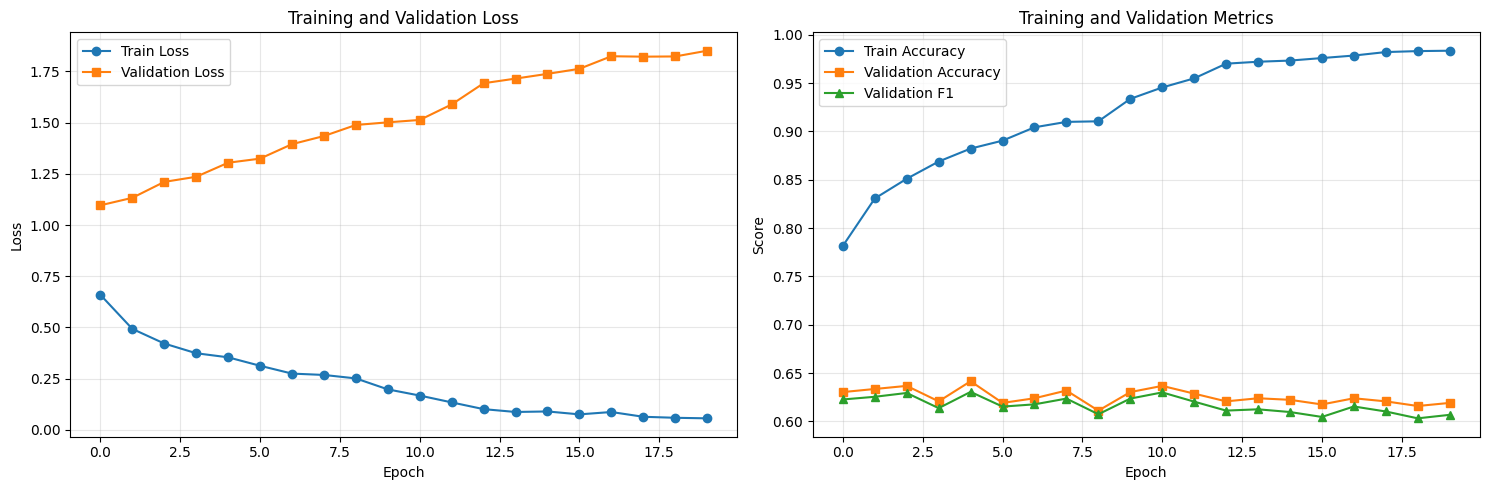

✓ Training curves saved to results/fusion_model/training_curves.png


In [23]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].plot(history['val_f1'], label='Validation F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {RESULTS_DIR}/training_curves.png")

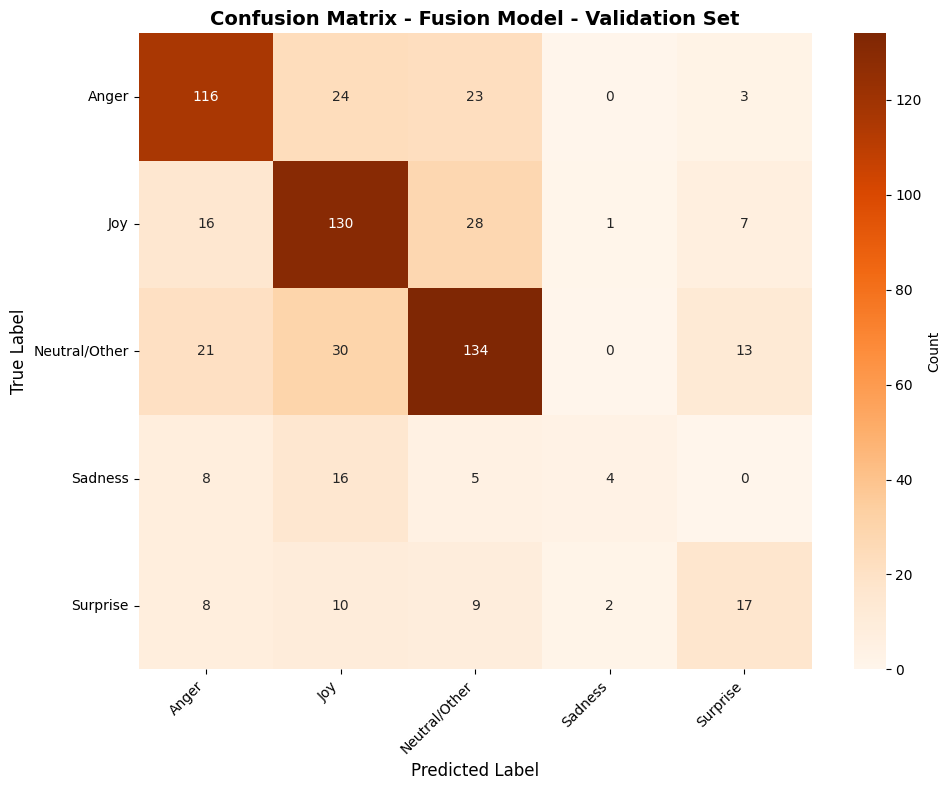

✓ Confusion matrix saved to results/fusion_model/confusion_matrix.png


In [24]:
# Plot confusion matrix
cm = confusion_matrix(val_labels_list, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Fusion Model - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {RESULTS_DIR}/confusion_matrix.png")

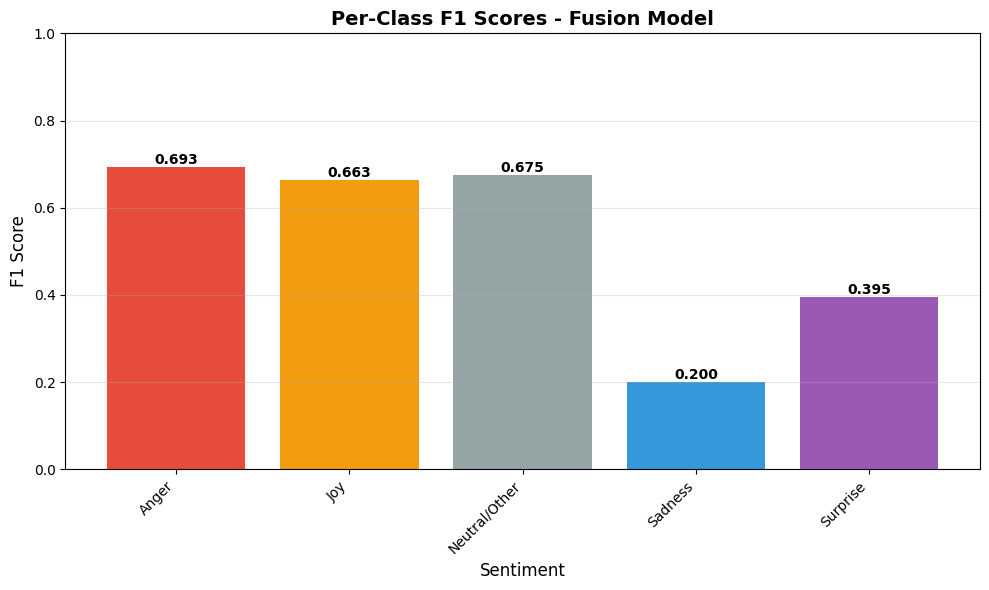

✓ Per-class F1 scores plot saved to results/fusion_model/f1_scores_per_class.png


In [25]:
# Plot per-class F1 scores
f1_scores = [metrics['per_class'][label]['f1_score'] for label in LABELS]

plt.figure(figsize=(10, 6))
bars = plt.bar(LABELS, f1_scores, color=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#9b59b6'])
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Per-Class F1 Scores - Fusion Model', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f1_scores_per_class.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-class F1 scores plot saved to {RESULTS_DIR}/f1_scores_per_class.png")

## 14. Summary

In [26]:
print("=" * 80)
print("FUSION MODEL TRAINING COMPLETE!")
print("=" * 80)
print("\nFiles Generated:")
print(f"  1. Model weights: {MODEL_DIR}/fusion_model.pth")
print(f"  2. Best model weights: {MODEL_DIR}/fusion_model_best.pth")
print(f"  3. Training history: {RESULTS_DIR}/training_history.json")
print(f"  4. Evaluation metrics: {RESULTS_DIR}/evaluation_metrics.json")
print(f"  5. Evaluation report: {RESULTS_DIR}/evaluation_report.txt")
print(f"  6. Training curves: {RESULTS_DIR}/training_curves.png")
print(f"  7. Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"  8. F1 scores per class: {RESULTS_DIR}/f1_scores_per_class.png")

print("\nFinal Performance:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")
print(f"  Best Epoch: {best_epoch}/{EPOCHS}")

print("\nPer-Class F1 Scores:")
for label in LABELS:
    f1 = metrics['per_class'][label]['f1_score']
    support = metrics['per_class'][label]['support']
    print(f"  {label:15s}: {f1:.4f} (n={support})")

print("\n" + "=" * 80)
print("PHASE 2 COMPLETE!")
print("=" * 80)
print("\nNext Step: Evaluation on Test Set - Step 6")
print("=" * 80)

FUSION MODEL TRAINING COMPLETE!

Files Generated:
  1. Model weights: models/fusion_model.pth
  2. Best model weights: models/fusion_model_best.pth
  3. Training history: results/fusion_model/training_history.json
  4. Evaluation metrics: results/fusion_model/evaluation_metrics.json
  5. Evaluation report: results/fusion_model/evaluation_report.txt
  6. Training curves: results/fusion_model/training_curves.png
  7. Confusion matrix: results/fusion_model/confusion_matrix.png
  8. F1 scores per class: results/fusion_model/f1_scores_per_class.png

Final Performance:
  Accuracy: 0.6416
  Weighted F1: 0.6306
  Best Epoch: 5/20

Per-Class F1 Scores:
  Anger          : 0.6925 (n=166)
  Joy            : 0.6633 (n=182)
  Neutral/Other  : 0.6751 (n=198)
  Sadness        : 0.2000 (n=33)
  Surprise       : 0.3953 (n=46)

PHASE 2 COMPLETE!

Next Step: Evaluation on Test Set - Step 6
